In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from datetime import datetime
import random
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.utils import Progbar
import time
import re

# EDA

<Figure size 720x360 with 0 Axes>

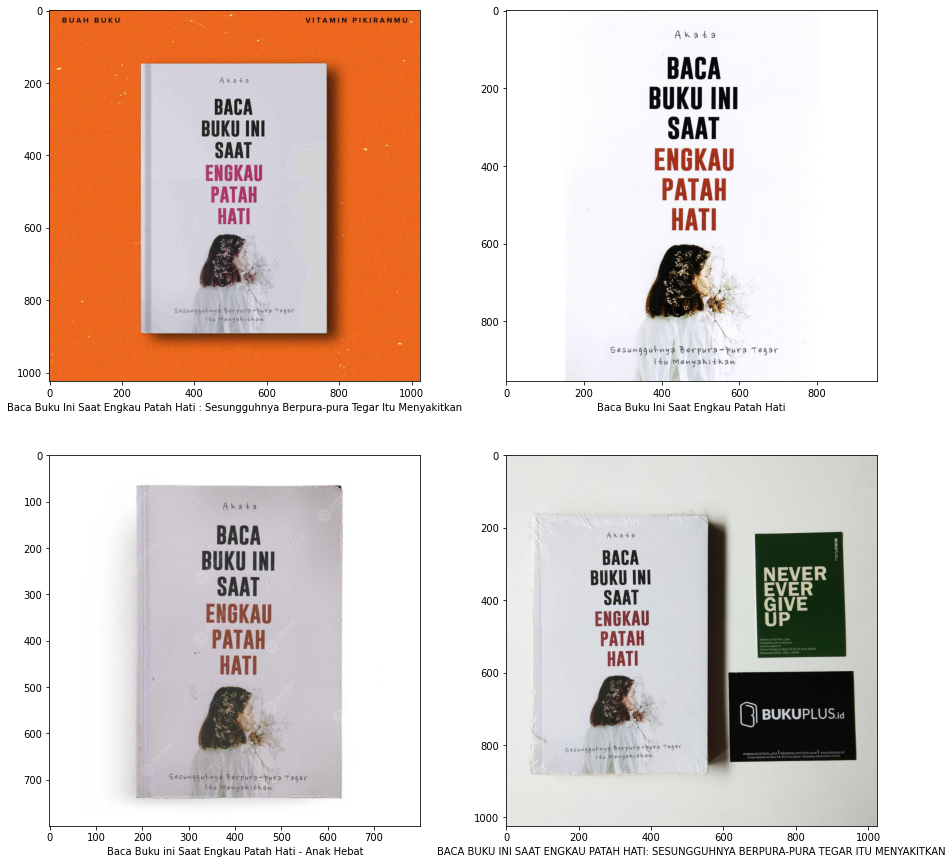

In [22]:
train_data = pd.read_csv('../input/shopee-product-matching/train.csv')
def plot_image(image_path, label_group, nrows, ncols):
    images = train_data[train_data['label_group'] == label_group]['image'].values
    plt.figure(figsize=(10,5))
    f, axarr = plt.subplots(nrows, ncols)
    f.set_figheight(15)
    f.set_figwidth(15)
    im = 0
    for i in range(nrows):
        for j in range(ncols):
            title = train_data[train_data['image'] == images[im]]['title'].values[0]
            img = plt.imread(os.path.join(image_path, images[im]))
            im = im + 1
            axarr[i, j].imshow(img)
            axarr[i, j].set_xlabel(title)
train_image_path = '/kaggle/input/shopee-product-matching/train_images/'
plot_image(train_image_path, 4294197112, 2, 2)

# Parameters

In [23]:
img_height = 50
img_width = 50
batch_size = 64
execution_mode = 'train-test'
learning_rate = 0.01
oov_token = '<oov>'
num_words = 15000
truncating = 'post'
padding = 'post'
embedding_dim = 100
max_len = 10
learning_rate = 0.001
epochs = 100
file_path = '/kaggle/input/shopee-product-matching/train.csv'

# Data Prep

In [24]:
def create_pair():
  pos_pair = []
  neg_pair = []
  train_data = pd.read_csv('../input/shopee-product-matching/train.csv')
  all_label_group = set(train_data['label_group'])
  for label in all_label_group:
    #Positive pair
    pos_list = train_data[train_data['label_group'] == label]['posting_id'].values
    for i in range(len(pos_list)-1):
      pos_pair.append([pos_list[i], pos_list[i+1], 1])
    #Negative pair
    neg_label = random.sample(all_label_group - set([label]), 1)[0]
    neg_list = train_data[train_data['label_group'] == neg_label]['posting_id'].values
    n = min(len(pos_list), len(neg_list))
    for i in range(n):
      neg_pair.append([pos_list[i], neg_list[i], 0])
  #Merge pos and neg pair
  all_pairs = pos_pair+ neg_pair
  #Create DataaFrame
  df_all_pairs = pd.DataFrame(data=all_pairs, columns=['posting_id1','posting_id2','label'])
  df_all_pairs = pd.merge(df_all_pairs, train_data, left_on='posting_id1', right_on='posting_id', how='inner')
  df_all_pairs = df_all_pairs[['posting_id1', 'posting_id2', 'image', 'title', 'label']]
  df_all_pairs = df_all_pairs.rename(columns={'image':'image1', 'title':'title1'})
  df_all_pairs = pd.merge(df_all_pairs, train_data, left_on='posting_id2', right_on='posting_id', how='inner')
  df_all_pairs = df_all_pairs[['posting_id1', 'posting_id2','image1','title1','image', 'title', 'label']]
  df_all_pairs = df_all_pairs.rename(columns={'image':'image2', 'title':'title2'})
  return df_all_pairs

def get_true_matches(train_data):
    all_matches = []
    for index, row in train_data.iterrows():
        posting_id1 = row['posting_id']
        matching_postings = train_data[train_data['label_group'] == row['label_group']]['posting_id'].values
        matching_postings = ' '.join(x for x in matching_postings)
        all_matches.append([posting_id1,matching_postings])
    return pd.DataFrame(data=all_matches, columns=['posting_id', 'matches'])

def get_f1_score(actual, predicted):
    f_score = []
    for index,row in actual.iterrows():
        id = row['posting_id']
        list = row['matches'].split()
        pred_list = predicted[predicted['posting_id'] == id]['matches'].values[0].split()
        ##F1 score
        tags = set(list)
        pred = set(pred_list)
        tp = len(tags & pred)
        fp = len(pred) - tp 
        fn = len(tags) - tp
        if tp>0:
            precision=float(tp)/(tp+fp)
            recall=float(tp)/(tp+fn)
            f_score.append(2*((precision*recall)/(precision+recall)))
        else:
            f_score.append(0)
    return np.array(f_score).mean()

def process_posting_id(image1, image2, title1, title2, label):
    dct = {}
    train_image_path = tf.constant('/kaggle/input/shopee-product-matching/train_images/')
    #Process Image1
    image1 = tf.strings.join([train_image_path, image1])
    image1 = tf.io.read_file(image1)
    image1 = tf.image.decode_jpeg(image1)
    image1 = tf.image.convert_image_dtype(image1, tf.float32)
    image1 = tf.image.resize(image1, [img_height, img_width])
    #Process Image2
    image2 = tf.strings.join([train_image_path, image2])
    image2 = tf.io.read_file(image2)
    image2 = tf.image.decode_jpeg(image2)
    image2 = tf.image.convert_image_dtype(image2, tf.float32)
    image2 = tf.image.resize(image2, [img_height, img_width])
    #Get the lable
    label = tf.expand_dims(tf.cast(label, tf.float32), axis=0)
    dct['image1'] = image1
    dct['image2'] = image2
    dct['title1'] = title1
    dct['title2'] = title2
    dct['label'] = label
    return dct

def create_sequence(data, col):
    seq = np.array(pad_sequences(tokenizer.texts_to_sequences([x for x in data[col].values]), maxlen=max_len, 
              truncating=truncating, padding=padding))
    return seq

#Learn Tokenizer for sequence
train_data = pd.read_csv('../input/shopee-product-matching/train.csv')
titles = []
for index, row in train_data.iterrows():
    titles.append(row['title'])
tokenizer = Tokenizer(oov_token=oov_token, num_words=num_words)
tokenizer.fit_on_texts(titles)

# Batched Dataset for training and validation

In [25]:
if execution_mode == 'train-test':
    paired_train_data = create_pair()
    training_data, testing_data = train_test_split(paired_train_data, test_size=0.1)
    print("Total number of Training records: {}".format(len(training_data['posting_id1'].values)))
    print("Total number of validation records: {}".format(len(testing_data['posting_id1'].values)))
    #Training Data Gen
    dataset = tf.data.Dataset.from_tensor_slices((training_data['image1'], training_data['image2'], 
                                                 create_sequence(training_data, 'title1'), 
                                                  create_sequence(training_data, 'title2'), training_data['label']))
    dataset = dataset.map(process_posting_id, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(1)
    #Validation Data Gen
    val_dataset = tf.data.Dataset.from_tensor_slices((testing_data['image1'], testing_data['image2'], 
                                                 create_sequence(testing_data, 'title1'), 
                                                  create_sequence(testing_data, 'title2'), testing_data['label']))
    val_dataset = val_dataset.map(process_posting_id, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(1)
else:
    paired_train_data = create_pair()
    training_data = paired_train_data
    print("Total number of Training records: {}".format(len(training_data['posting_id1'].values)))
    #Training Data Gen
    dataset = tf.data.Dataset.from_tensor_slices((training_data['image1'], training_data['image2'], 
                                                 create_sequence(training_data, 'title1'), 
                                                  create_sequence(training_data, 'title2'), training_data['label']))
    dataset = dataset.map(process_posting_id, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(1)

Total number of Training records: 42804
Total number of validation records: 4756


# Model

In [26]:
def base_model():
    #For Image Data
    input = tf.keras.layers.Input(shape=(img_height,img_width,3), name='base_image_input')
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(input)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    #For Sequence Data
    input_seq = tf.keras.layers.Input(shape=(max_len), name='base_seq_input')
    x_seq = tf.keras.layers.Embedding(input_dim=num_words+1, output_dim=embedding_dim,
                              input_length=max_len)(input_seq)
    x_seq = tf.keras.layers.GlobalAveragePooling1D()(x_seq)
    x_seq = tf.keras.layers.Dense(128, activation='relu')(x_seq)
    #Concat image and text
    out_concat = tf.keras.layers.Concatenate()([x, x_seq])
    #define model
    model = Model(inputs=[input, input_seq], outputs=out_concat)
    return model
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss
#Define Model
base_network = base_model()

input_a = tf.keras.layers.Input(shape=(img_height, img_width, 3), name='input_a')
input_a_seq = tf.keras.layers.Input(shape=(max_len), name='input_a_seq')
vec_output_a = base_network([input_a, input_a_seq])

input_b = tf.keras.layers.Input(shape=(img_height, img_width, 3), name='input_b')
input_b_seq = tf.keras.layers.Input(shape=(max_len), name='input_b_seq')
vec_output_b = base_network([input_b, input_b_seq])
output = tf.keras.layers.Lambda(euclidean_distance, name='output_layer', 
                                    output_shape=eucl_dist_output_shape)([vec_output_a, vec_output_b])
my_model = Model(inputs=[input_a, input_a_seq, input_b, input_b_seq], outputs=output)
#plot_model(my_model, show_shapes=True, show_layer_names=True, to_file='base-model.png')

# Optimizer and Loss

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss = contrastive_loss_with_margin(1)
my_model.compile(optimizer=optimizer, loss=loss)

# Custom Training

In [28]:
def train_model(my_model, dataset, optimizer, loss):
    with tf.GradientTape() as tap:
        input_a = dataset['image1']
        input_a_seq = dataset['title1']
        input_b = dataset['image2']
        input_b_seq = dataset['title2']
        label = dataset['label']
        output = my_model([input_a, input_a_seq, input_b, input_b_seq])
        loss_value = loss(label, output)
    gradients = tap.gradient(loss_value, my_model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, my_model.trainable_weights))
    return loss_value

def train_data_for_one_epoch(dataset, my_model, optimizer, loss):
    losses = []
    for step, single_batch in enumerate(dataset):
        time.sleep(0.3)
        loss_value = train_model(my_model, single_batch, optimizer, loss)
        losses.append(loss_value.numpy())
        pb_i.add(batch_size)
    return np.mean(losses)

def perform_validation(my_model, val_dataset):
    val_loss = []
    for step, single_batch in enumerate(val_dataset):
        input_a = single_batch['image1']
        input_a_seq = single_batch['title1']
        input_b = single_batch['image2']
        input_b_seq = single_batch['title2']
        y_pred = my_model([input_a, input_a_seq, input_b, input_b_seq])
        val_loss.append(loss(single_batch['label'], y_pred))
    return np.mean(val_loss)

#Custom Training
epochs = range(1)
num_training_samples = training_data['image1'].count()
for epoch in epochs:
    pb_i = Progbar(num_training_samples)
    epoch = epoch + 1
    start_time = datetime.now()
    #Train model for one epoch
    losses = train_data_for_one_epoch(dataset, my_model, optimizer, loss)
    val_loss = perform_validation(my_model, val_dataset)
    #val_loss = 0
    #Train End time for one epoch
    end_time = datetime.now()
    time_taken_for_one_epoch = (end_time-start_time).total_seconds()
    print('\n Epoch %s time taken: %.4f: Train loss: %.4f  Validation Loss: %.4f,' % \
          (epoch, float(time_taken_for_one_epoch), float(losses), float(val_loss)))

42816/42804 [==============================] - 377s 9ms/step

 Epoch 1 time taken: 407.3677: Train loss: 0.1047  Validation Loss: 0.0664,


# Save Model

In [29]:
if execution_mode == 'train-test':
    base_network.save('base_network.h5')

# Evaluation

In [32]:
#Read model for inference
if execution_mode == 'train-test':
    base_network = tf.keras.models.load_model('base_network.h5')
else:
    base_network = tf.keras.models.load_model('../input/shoppe-pred-base-network/base_network.h5')

In [50]:
def process_images(image, title):
    dct = {}
    image_path = '/kaggle/input/shopee-product-matching/train_images/'
    image_path = tf.constant(image_path)
    #Process Image
    img = tf.strings.join([image_path, image])
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    dct['image'] = img
    dct['title'] = title
    return dct
def process_test_images(image, title):
    dct = {}
    image_path = tf.constant('/kaggle/input/shopee-product-matching/test_images/')
    #Process Image
    img = tf.strings.join([image_path, image])
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    dct['image'] = img
    dct['title'] = title
    return dct
def make_prediction(data, train_test, thld):
    pred_dataset = tf.data.Dataset.from_tensor_slices((data['image'], create_sequence(data, 'title')))
    if train_test == 'train':
        pred_dataset = pred_dataset.map(process_images, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        pred_dataset = pred_dataset.map(process_test_images, num_parallel_calls=tf.data.AUTOTUNE)
    
    pred_dataset = pred_dataset.batch(batch_size).prefetch(1)
    pred_vecs = []
    for step, single_batch in enumerate(pred_dataset):
        if step == 0:
            pred_vecs = base_network.predict([single_batch['image'], single_batch['title']])
        else:
            pred_vec = base_network.predict([single_batch['image'], single_batch['title']])
            pred_vecs = np.concatenate((pred_vecs,pred_vec), axis=0)
    all_posting_ids = data['posting_id'].values
    iter1 = 0
    all_matches = []
    for vec1 in pred_vecs:
        vec1 = np.expand_dims(vec1, axis=0)
        dist = np.sqrt((np.square(vec1[:,np.newaxis]-pred_vecs).sum(axis=2)))
        match_indices = np.where(dist[0] < thld)[0]
        res_list = [all_posting_ids[i] for i in match_indices]
        matches = ' '.join(x for x in res_list)
        all_matches.append([all_posting_ids[iter1], matches])
        iter1 = iter1 + 1
    return pd.DataFrame(data=all_matches, columns=['posting_id', 'matches'])

#Evaluation on Training Data
train_data = pd.read_csv('../input/shopee-product-matching/train.csv')
#true_matches = get_true_matches(train_data)
#predicted_matches = make_prediction(train_data, 'train', 0.5)
#print("Training F1 Score: {}".format(get_f1_score(true_matches, predicted_matches)))

if execution_mode == 'train-test':
    #Evaluation on Test Data
    id1 = testing_data['posting_id1'].unique()
    id2 = testing_data['posting_id2'].unique()
    ids = set(np.concatenate((id1, id2), axis=None))
    val_df = pd.DataFrame(data=ids, columns=['lkp_posting_id'])
    val_df = pd.merge(train_data, val_df, left_on=['posting_id'], right_on=['lkp_posting_id'], how='inner')
    true_matches = get_true_matches(val_df)
    predicted_matches = make_prediction(val_df, 'train', 0.2)
    print("Validation F1 Score: {}".format(get_f1_score(true_matches, predicted_matches)))

Validation F1 Score: 0.6415152846654215


Some manual Evaluation

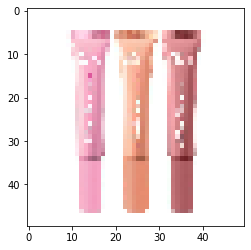

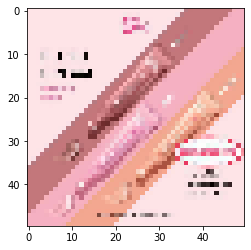

[1.]
[[0.02217275]]
[2056 1124   29    7   52    3    0    0    0    0]
[2056 1124   29    7   52    3    0    0    0    0]


In [49]:
for dat in val_dataset:
    idx = 15
    img1 = dat['image1'].numpy()[idx]
    seq1 = dat['title1'].numpy()[idx]
    img2 = dat['image2'].numpy()[idx]
    seq2 = dat['title2'].numpy()[idx]
    label = dat['label'].numpy()[idx]
    plt.figure()
    plt.imshow(img1)
    plt.figure()
    plt.imshow(img2)
    plt.show()
    print(label)
    #print(my_model.predict([np.expand_dims(img1, axis=0), np.expand_dims(img2, axis=0)]))
    vec1 = base_network.predict([np.expand_dims(img1, axis=0), np.expand_dims(seq1, axis=0)])
    vec2 = base_network.predict([np.expand_dims(img2, axis=0), np.expand_dims(seq2, axis=0)])
    #print(euclidean_distance([vec1, vec2]))
    print(np.sqrt((np.square(vec1[:,np.newaxis]-vec2).sum(axis=2))))
    print(seq1)
    print(seq2)
    break

# Prediction

In [ ]:
test_data = pd.read_csv('/kaggle/input/shopee-product-matching/test.csv')
submission_df = make_prediction(test_data, 'test', .1)
submission_df.to_csv('./submission.csv', index=False)
submission_df.head()